In [5]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy.signal as sig
import scipy.integrate as sciint
from functools import partial

# Mine
from wilson_cowan_2d.simulations import concrete_wc_kernel as wck
from wilson_cowan_2d.simulations import wc_params as wcp
from wilson_cowan_2d.simulations.nonlinear_functions import decreasing_exponential

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
τe = 1
τi = 0.6 * τe
u_bar, v_bar = 0.424, 0.204

param = wcp.DefaultParams(τ = np.array([τe, τi]), η = 0.1, size = 2**8)
# param.Θ = np.array([0.08, 0.4])



In [7]:
def calc_D0(u_bar, v_bar, param):
    bs = calc_bs(param, u_bar, v_bar)
    return (1 - bs[0,0])*(1 + bs[1,1]) + bs[0,1]*bs[1,0]


def calc_bs(param, u_bar, v_bar):
    return param.A * derv_F(param, u_bar, v_bar).reshape(2, 1)


def derv_F(param, u_bar, v_bar):
    ss = ss_F(param, u_bar, v_bar)
    return param.β * ss*(1 - ss)


def ss_F(param, u_bar, v_bar):
    return param.F(param.A[:, 0]*u_bar - param.A[:,1]*v_bar - param.Θ)


def analytic_FT_decexp(σ, ω):
    res = 1/(1 + (σ * ω)**2)
    return res

In [8]:
# ss_F(param, 1, 1)

# derv_F(param, 1, 1)

# param.A * derv_F(param, 0.25, 0.5).reshape(2,1)

# calc_bs(param, 0.25, 0.3)

# u_bar = 0.25
# v_bar = 0.5

# # e,e
# tt = param.F(param.A[0,0]*u_bar - param.A[0,1]*v_bar - param.Θ[0])
# ee = param.A[0,0] * param.β * tt * (1 - tt)

# # e, i
# tt = param.F(param.A[0,0]*u_bar - param.A[0,1]*v_bar - param.Θ[0])
# ei = param.A[0,1] * param.β * tt * (1 - tt)

# # i, e
# tt = param.F(param.A[1,0]*u_bar - param.A[1,1]*v_bar - param.Θ[1])
# ie = param.A[1,0] * param.β * tt * (1 - tt)

# # i, e
# tt = param.F(param.A[1,0]*u_bar - param.A[1,1]*v_bar - param.Θ[1])
# ii = param.A[1,1] * param.β * tt * (1 - tt)
# print(ee, ei)
# print(ie, ii)

In [9]:
rang = np.linspace(0,1,100)
mesh = np.array([[calc_D0(x, y, param) for x in rang] for y in rang])

np.where(mesh == np.max(mesh))

(array([22]), array([45]))

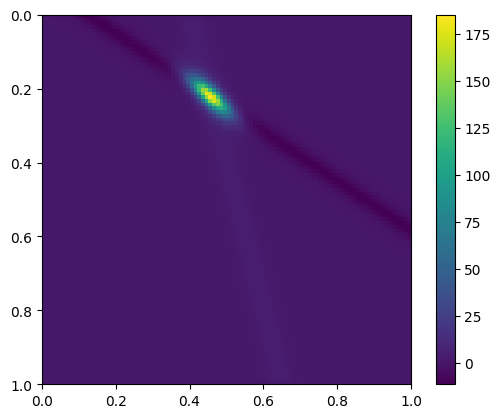

In [10]:
_ = plt.imshow(mesh, extent=[0,1,1,0])
plt.colorbar()

In [11]:
de = [decreasing_exponential(np.abs(np.linspace(-6, 6, 2*200-1)), x) for x in range(1,10)]
# de = [x/x.sum() for x in de]

200 200


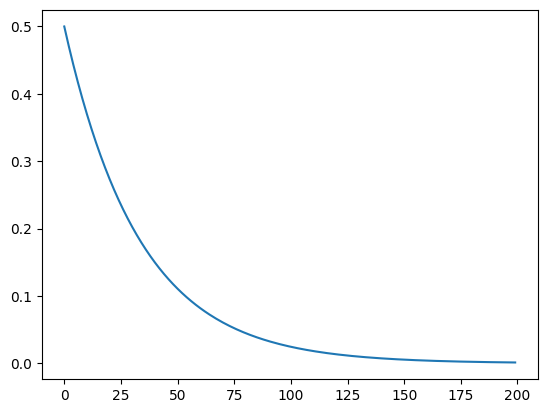

In [12]:
rr = 0.2*np.zeros(200)
rr[0] = 1 # np.linspace(0, 2**12, 500)
conv = np.convolve(rr, de[0], 'valid')
print(conv.size, rr.size)
_ = plt.plot(conv)

In [13]:
rang = np.linspace(0, 100, 10_000)
anl_powers = [analytic_FT_decexp(i, rang) for i in range(1,10)]
# _ = [plt.plot(rang, ap, label=f"σ = {i}") for i in range(1,10)]
# _ = plt.legend()
# _ = plt.xlim(0.4, 2)

e_ix = 0
i_ix = 1
bs = calc_bs(param, 0.424, 0.2047)  # u_bar == 0.42, v_bar == 0.2
σe = 4
e_ft = analytic_FT_decexp(1*σe, rang)
# e_ft = e_ft/e_ft[0]
i2_ft = analytic_FT_decexp(2*σe, rang)
# i2_ft = i2_ft/i2_ft[0]

i3_ft = analytic_FT_decexp(3*σe, rang)
# i3_ft = i3_ft/i3_ft[0]

i5_ft = analytic_FT_decexp(5*σe, rang)
# i5_ft = i5_ft/i5_ft[0]

i7_ft = analytic_FT_decexp(7*σe, rang)
# i7_ft = i7_ft/i7_ft[0]

Dω2 = (1 - bs[0,0]*e_ft)*(1 + bs[1,1]*i2_ft) + bs[0,1]*bs[1,0]*e_ft*i2_ft
Dω3 = (1 - bs[0,0]*e_ft)*(1 + bs[1,1]*i3_ft) + bs[0,1]*bs[1,0]*e_ft*i3_ft
Dω5 = (1 - bs[0,0]*e_ft)*(1 + bs[1,1]*i5_ft) + bs[0,1]*bs[1,0]*e_ft*i5_ft
Dω7 = (1 - bs[0,0]*e_ft)*(1 + bs[1,1]*i7_ft) + bs[0,1]*bs[1,0]*e_ft*i7_ft
# Dω = Dω/Dω[0]
# Dω_iix = lambda i_ix: (1 - bs[0,0]*e_ft)*(1 + bs[1,1]*i_ft) + bs[0,1]*bs[1,0]*e_ft*i_ft

# Dωs = [Dω_iix(x) for x in range(2, 9)]
# Dωs = [d/d[0] for d in Dωs]

In [14]:
def calc_Dω_range(param, equib_point, σe, σi_range, point_range=np.linspace(0,100,1_000)):
    bs = calc_bs(param, equib_point[0], equib_point[1])
    e_ft = analytic_FT_decexp(σe, point_range)
    
    return [_Dω_equation(bs, e_ft,analytic_FT_decexp(σi, point_range)) for σi in σi_range]
    

def calc_Dω(param, equib_point, σ, point_range = np.linspace(0,100,1_000)):
    bs = calc_bs(param, equib_point[0], equib_point[1])
    e_ft = analytic_FT_decexp(σ[0], point_range)
    i_ft = analytic_FT_decexp(σ[1], point_range)
    
    return _Dω_equation(bs, e_ft, i_ft)


def _Dω_equation(bs, e_ft, i_ft):
    return (1 - bs[0,0]*e_ft)*(1 + bs[1,1]*i_ft) + bs[0,1]*bs[1,0]*e_ft*i_ft

In [15]:
rang = np.linspace(0,100, 10_000)
dw_test = calc_Dω_range(param, (u_bar, v_bar), 1, (2,3,5), rang)

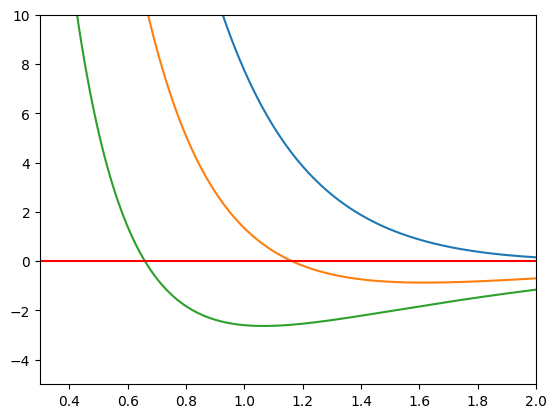

In [16]:
_ = [plt.plot(rang, dw) for dw in dw_test]
# _ = plt.legend()
_ = plt.xlim(0.3, 2)
_ = plt.ylim(-5, 10)
_ = plt.hlines(0,0,1_000, color='r')